# OLED Optimization with FourierFields


In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from meep.materials import Al as ALU

mp.verbosity(0)

GLS = mp.Medium(index=1.5)    # 글래스의 굴절률 설정
ITO = mp.Medium(index=1.2)    # ITO의 굴절률 설정
ORG = mp.Medium(index=1.75)   # OLED 유기층의 굴절률 설정
SiN = mp.Medium(index=1.9)    # 실리콘 질화물의 굴절률 설정

Basic setup

In [3]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.8       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 25             # 추출할 주파수 개수
design_region_resolution = 50                                                             

tABS = 0.5    # X/Y 방향 흡수 경계층 두께
tPML = 0.5    # Z 방향 PML 경계층 두께
tGLS = 0.5    # 글래스 층 두께
tITO = 0.5    # ITO 층 두께
tORG = 0.5    # 유기층(OLED 발광층) 두께
tALU = 0.2    # 알루미늄(캐소드) 두께

L = 1.0       # OLED의 가로/세로 길이

design_region_width = L
design_region_height = 0.2

Sy = tPML + tGLS + design_region_height + tITO + tORG + tALU  # Z 방향 전체 길이
Sx = L + 2*tABS                        # X/Y 방향 길이
cell_size = mp.Vector3(Sx, Sy)    # 시뮬레이션 셀 크기

boundary_layers = [mp.Absorber(tABS,direction=mp.X),
                   mp.PML(tPML,direction=mp.Y,side=mp.High)]

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), GLS, SiN, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(y=0.5*Sy - tPML - tGLS - 0.5*design_region_height),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

geometry = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=design_variables,      # 디자인 영역
             size=design_region.size,
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

sources = [
    mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),     # 연속파 광원
              component=mp.Ez,                # z 방향 전기장
              center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))
]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[ALU],)
                    

<Axes: xlabel='X', ylabel='Y'>

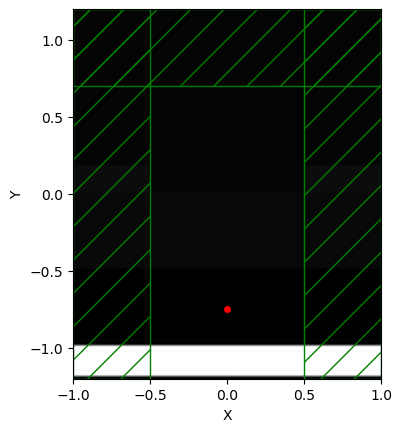

In [4]:
sim.plot2D()

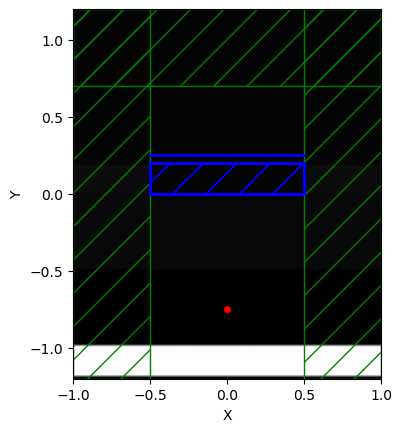

In [5]:
monitor_position, monitor_size = mp.Vector3(0,0.5*Sy-tPML-(tGLS-0.05)), mp.Vector3(L,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields[:,:]) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)
opt.plot2D(True)

In [6]:
minimum_length = 0.02  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

In [7]:
def mapping(x, eta, beta):

    # # filter
    # filtered_field = mpa.conic_filter(
    #     x,
    #     filter_radius,
    #     design_region_width,
    #     design_region_height,
    #     design_region_resolution,
    # )

    # # projection
    # projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return x

In [8]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient

    print("FoM: {}".format(np.real(f0)))
    print("Gradient: {}".format(np.real(dJ_du)))

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, dJ_du
        )  # backprop

    evaluation_history.append(np.real(f0))

    print("First FoM: {}".format(evaluation_history[0]))
    print("Current FoM: {}".format(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [9]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 9
update_factor = 12
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
Starting adjoint run...


Calculating gradient...
FoM: 0.09012056967309394
Gradient: [ 1.48983756e-04  3.82304087e-04  4.82300454e-04  4.89042428e-04
  3.80155404e-04  1.49397384e-04 -1.55283012e-04 -3.61369330e-04
 -4.59572485e-04 -4.34498416e-04 -4.35009276e-04  1.24172561e-04
  3.27242240e-04  4.36373912e-04  4.76188118e-04  4.18837660e-04
  2.65449150e-04  4.90079696e-06 -1.72499412e-04 -2.64140218e-04
 -2.52023700e-04 -2.01473080e-04  1.18402640e-04  3.24286401e-04
  4.61997816e-04  5.34987815e-04  5.04294007e-04  3.71909837e-04
  9.14739077e-05 -1.01971243e-04 -2.04954270e-04 -1.92998722e-04
 -8.80725709e-05  8.76651949e-05  2.58977996e-04  4.11615396e-04
  5.14241599e-04  5.18357216e-04  4.22191040e-04  1.52626772e-04
 -3.78187767e-05 -1.40176186e-04 -1.24027619e-04  3.77649458e-05
  3.93965608e-05  1.47380416e-04  2.98835847e-04  4.22932182e-04
  4.64287467e-04  4.13023286e-04  1.80424883e-04  8.81025273e-06
 -8.33090253e-05 -6.02300100e-05  1.51166000e-04 -1.51433029e-05
  1.55378446e-05  1.50603755e-0

Calculating gradient...
FoM: 0.09012700677774989
Gradient: [ 1.49013963e-04  3.82378143e-04  4.82387301e-04  4.89129458e-04
  3.80226930e-04  1.49443237e-04 -1.55270596e-04 -3.61373418e-04
 -4.59585522e-04 -4.34515405e-04 -4.35037096e-04  1.24195599e-04
  3.27301899e-04  4.36451905e-04  4.76274775e-04  4.18918430e-04
  2.65514692e-04  4.93472395e-06 -1.72482073e-04 -2.64133586e-04
 -2.52023641e-04 -2.01479950e-04  1.18421990e-04  3.24339332e-04
  4.62073795e-04  5.35078671e-04  5.04384531e-04  3.71989215e-04
  9.15193316e-05 -1.01944339e-04 -2.04939597e-04 -1.92991430e-04
 -8.80685438e-05  8.76758166e-05  2.59010690e-04  4.11670620e-04
  5.14314761e-04  5.18435638e-04  4.22264000e-04  1.52670602e-04
 -3.77911104e-05 -1.40158518e-04 -1.24014736e-04  3.77829259e-05
  3.93961799e-05  1.47385812e-04  2.98858268e-04  4.22971589e-04
  4.64336220e-04  4.13072628e-04  1.80456009e-04  8.83158918e-06
 -8.32919519e-05 -6.02121289e-05  1.51201608e-04 -1.51533785e-05
  1.55178366e-05  1.50592282e-0

Calculating gradient...
FoM: 0.09019123222627073
Gradient: [ 1.49315025e-04  3.83116327e-04  4.83253152e-04  4.89997274e-04
  3.80940273e-04  1.49900633e-04 -1.55146660e-04 -3.61414112e-04
 -4.59715498e-04 -4.34684790e-04 -4.35314430e-04  1.24425256e-04
  3.27896690e-04  4.37229632e-04  4.77139019e-04  4.19724075e-04
  2.66168555e-04  5.27322105e-06 -1.72309066e-04 -2.64067416e-04
 -2.52023056e-04 -2.01548471e-04  1.18614884e-04  3.24867044e-04
  4.62831448e-04  5.35984808e-04  5.05287477e-04  3.72781099e-04
  9.19725063e-05 -1.01675953e-04 -2.04793278e-04 -1.92918777e-04
 -8.80285312e-05  8.77816645e-05  2.59336588e-04  4.12221260e-04
  5.15044396e-04  5.19217829e-04  4.22991826e-04  1.53107840e-04
 -3.75151711e-05 -1.39982394e-04 -1.23886420e-04  3.79619320e-05
  3.93923032e-05  1.47439460e-04  2.99081741e-04  4.23364520e-04
  4.64822450e-04  4.13564832e-04  1.80766506e-04  9.04435983e-06
 -8.31218063e-05 -6.00340179e-05  1.51556319e-04 -1.52539174e-05
  1.53181671e-05  1.50477731e-0

Calculating gradient...
FoM: 0.09109236323073248
Gradient: [ 1.53481938e-04  3.93347051e-04  4.95285371e-04  5.02082406e-04
  3.90896287e-04  1.56303682e-04 -1.53394172e-04 -3.61959333e-04
 -4.61509394e-04 -4.37028957e-04 -4.39149393e-04  1.27611434e-04
  3.36160742e-04  4.48063186e-04  4.89200122e-04  4.30987996e-04
  2.75328625e-04  1.00231065e-05 -1.69876270e-04 -2.63132772e-04
 -2.52008364e-04 -2.02496952e-04  1.21290283e-04  3.32199420e-04
  4.73387592e-04  5.48632068e-04  5.17910916e-04  3.83871344e-04
  9.83234205e-05 -9.79172361e-05 -2.02750071e-04 -1.91912728e-04
 -8.74900963e-05  8.92431555e-05  2.63852315e-04  4.19882849e-04
  5.25218863e-04  5.30144070e-04  4.33176706e-04  1.59228268e-04
 -3.36617942e-05 -1.37537482e-04 -1.22121004e-04  4.04100925e-05
  3.93240829e-05  1.48156538e-04  3.02171439e-04  4.28828960e-04
  4.71603594e-04  4.20444999e-04  1.85107962e-04  1.20072327e-05
 -8.07702554e-05 -5.75849546e-05  1.56438119e-04 -1.66662113e-05
  1.25088214e-05  1.48852990e-0

Calculating gradient...
FoM: 0.10153705399959242
Gradient: [ 1.95689908e-04  4.98419673e-04  6.22230339e-04  6.32234833e-04
  5.00145328e-04  2.28027378e-04 -1.32654430e-04 -3.66413527e-04
 -4.79698242e-04 -4.61074138e-04 -4.77951497e-04  1.60731533e-04
  4.23421870e-04  5.65585084e-04  6.22622078e-04  5.57799552e-04
  3.80302877e-04  6.52262028e-05 -1.41020819e-04 -2.51431199e-04
 -2.50844594e-04 -2.11681530e-04  1.48995948e-04  4.09628772e-04
  5.88203355e-04  6.88922051e-04  6.60305127e-04  5.11075612e-04
  1.71778964e-04 -5.44719043e-05 -1.79412981e-04 -1.80932996e-04
 -8.27718878e-05  1.03587064e-04  3.09998336e-04  5.01876761e-04
  6.36890754e-04  6.52343520e-04  5.49140148e-04  2.29424991e-04
  9.95520375e-06 -1.10969118e-04 -1.04339747e-04  6.32439264e-05
  3.69035353e-05  1.52255756e-04  3.32600113e-04  4.86635317e-04
  5.45751889e-04  4.97598050e-04  2.34305193e-04  4.47801561e-05
 -5.62401437e-05 -3.33887479e-05  2.04169344e-04 -3.33778030e-05
 -2.14182129e-05  1.27257037e-0

Calculating gradient...
FoM: 0.15196768775606187
Gradient: [ 2.91383609e-04  7.65438441e-04  1.01537875e-03  1.10342923e-03
  9.59722326e-04  5.89549799e-04  3.86871428e-06 -3.62304642e-04
 -5.62726390e-04 -5.88533447e-04 -6.87497780e-04  2.53796361e-04
  6.97028373e-04  1.00276619e-03  1.18834168e-03  1.16753401e-03
  9.63137972e-04  4.11489204e-04  5.40679139e-05 -1.66808987e-04
 -2.39618532e-04 -2.66997440e-04  2.26337315e-04  6.57867775e-04
  1.03102919e-03  1.30422757e-03  1.36338852e-03  1.22992534e-03
  6.38103099e-04  2.30443616e-04 -3.23454726e-05 -1.28966493e-04
 -1.02243531e-04  1.29217279e-04  4.32327869e-04  8.00768355e-04
  1.11579196e-03  1.24863069e-03  1.20036540e-03  6.75102718e-04
  2.88828594e-04  3.60419150e-05 -4.63924049e-05  7.00944645e-05
 -2.51838089e-06  1.02122755e-04  3.97647641e-04  7.00384989e-04
  8.83777250e-04  9.16618377e-04  5.40609914e-04  2.40427923e-04
  4.93417288e-05  1.85690775e-05  2.60869946e-04 -1.20042060e-04
 -2.10615152e-04 -2.90977715e-0

Calculating gradient...
FoM: 0.15862511924358821
Gradient: [ 3.32569144e-04  8.07872628e-04  9.12046179e-04  8.19811092e-04
  5.02225822e-04 -5.55578034e-05 -5.85348571e-04 -8.89250719e-04
 -9.87554760e-04 -8.97635645e-04 -9.74647192e-04  3.01627644e-04
  7.88375256e-04  1.04130070e-03  1.14510992e-03  1.03760227e-03
  7.49134427e-04  2.15260564e-04 -1.12392922e-04 -2.82596893e-04
 -3.00841827e-04 -2.90358245e-04  2.80970290e-04  7.81021704e-04
  1.14531136e-03  1.37935211e-03  1.38652636e-03  1.21121830e-03
  6.20890576e-04  2.32471848e-04 -5.61483625e-06 -7.82826793e-05
 -1.95925507e-05  1.71445593e-04  5.39916030e-04  9.33363577e-04
  1.24527483e-03  1.35718645e-03  1.29976575e-03  7.69425459e-04
  3.99442468e-04  1.55731431e-04  7.39285288e-05  2.03053537e-04
  7.42026985e-06  1.42390782e-04  4.78750976e-04  7.98944227e-04
  9.81334646e-04  1.02005276e-03  6.46083997e-04  3.68975174e-04
  1.92983120e-04  1.60864284e-04  4.04149646e-04 -1.55763083e-04
 -2.72274077e-04 -4.65528805e-0

Calculating gradient...
FoM: 0.157099976310223
Gradient: [ 4.69400294e-04  1.25037574e-03  1.71825830e-03  1.99207299e-03
  1.95848278e-03  1.67528891e-03  8.50746158e-04  3.08401970e-04
 -7.89931464e-05 -2.79535646e-04 -4.77102783e-04  3.57173713e-04
  9.86658702e-04  1.44156926e-03  1.76110520e-03  1.82889660e-03
  1.70716269e-03  1.00840180e-03  5.21666753e-04  1.61087086e-04
 -3.79504175e-05 -1.46035491e-04  2.89107703e-04  8.41632977e-04
  1.32813428e-03  1.71046559e-03  1.85095585e-03  1.80324801e-03
  1.11238958e-03  6.03082856e-04  2.18288784e-04  1.36128945e-05
 -4.17694759e-05  1.47405714e-04  4.92953454e-04  9.15968499e-04
  1.29063655e-03  1.47583318e-03  1.48713328e-03  9.24920938e-04
  4.90603457e-04  1.66987596e-04  2.26310067e-05  8.76225712e-05
 -7.75849358e-06  8.80480814e-05  3.79406260e-04  6.84971780e-04
  8.79729745e-04  9.32116960e-04  5.70308897e-04  2.74521154e-04
  7.85796981e-05  4.86538433e-05  3.11517334e-04 -1.15060791e-04
 -2.14467800e-04 -7.37485183e-05 

Calculating gradient...
FoM: 0.16412185856472214
Gradient: [ 4.41760686e-04  1.14440159e-03  1.49079381e-03  1.63133028e-03
  1.48128186e-03  1.07671245e-03  3.10909248e-04 -1.73345411e-04
 -4.68930946e-04 -5.61476899e-04 -7.22018978e-04  3.61347664e-04
  9.78657025e-04  1.38213015e-03  1.63503608e-03  1.63602360e-03
  1.44084197e-03  7.55973535e-04  3.00138959e-04 -8.88895745e-06
 -1.47225055e-04 -2.12518585e-04  3.10468209e-04  8.86569033e-04
  1.35866961e-03  1.70665211e-03  1.80056747e-03  1.69559756e-03
  9.93606555e-04  4.97871102e-04  1.45658054e-04 -1.88508168e-05
 -3.03584627e-05  1.71294234e-04  5.56555913e-04  1.00013709e-03
  1.37533023e-03  1.54066009e-03  1.52072101e-03  9.28453984e-04
  4.90270651e-04  1.78130669e-04  5.03971605e-05  1.45894945e-04
 -2.51549117e-06  1.17275772e-04  4.51366272e-04  7.85271779e-04
  9.86376975e-04  1.03283566e-03  6.39106917e-04  3.32462316e-04
  1.34782511e-04  1.04266111e-04  3.77308017e-04 -1.46500120e-04
 -2.66318854e-04 -7.62705303e-0

Calculating gradient...
FoM: 0.16682314573729687
Gradient: [ 4.00246752e-04  1.01558273e-03  1.26586014e-03  1.30755076e-03
  1.07485018e-03  5.73710962e-04 -1.31818049e-04 -5.76145468e-04
 -8.10102610e-04 -8.29247834e-04 -9.96232023e-04  3.42317508e-04
  9.19639488e-04  1.27903308e-03  1.48646241e-03  1.45068175e-03
  1.21547486e-03  5.61391768e-04  1.27858545e-04 -1.48861037e-04
 -2.50633342e-04 -3.05278499e-04  3.00214438e-04  8.56689953e-04
  1.31019247e-03  1.63897427e-03  1.71877626e-03  1.60087143e-03
  9.16964472e-04  4.35427003e-04  9.87587491e-05 -5.03321005e-05
 -5.34899521e-05  1.63250909e-04  5.39945164e-04  9.87784420e-04
  1.36847054e-03  1.54177501e-03  1.53505235e-03  9.52236046e-04
  5.18679933e-04  2.04213269e-04  6.85414638e-05  1.52534596e-04
 -1.91218993e-05  8.58216131e-05  4.36770199e-04  7.91148048e-04
  1.01498014e-03  1.09069541e-03  7.05657596e-04  3.98588468e-04
  1.86987224e-04  1.31536819e-04  3.61510944e-04 -1.80988187e-04
 -3.37577820e-04 -1.29039531e-0

Calculating gradient...
FoM: 0.16864471821190188
Gradient: [ 4.54220212e-04  1.18134396e-03  1.55057345e-03  1.70929246e-03
  1.56413323e-03  1.14563953e-03  3.20481716e-04 -2.17056294e-04
 -5.58364980e-04 -6.77681731e-04 -9.06091900e-04  3.66717094e-04
  1.00144319e-03  1.43464286e-03  1.71988210e-03  1.74667013e-03
  1.57163612e-03  8.49118645e-04  3.54168272e-04  1.28894156e-06
 -1.69327524e-04 -2.72667916e-04  3.05976888e-04  8.87536013e-04
  1.39225159e-03  1.78194782e-03  1.91641037e-03  1.85285342e-03
  1.12804546e-03  5.98781483e-04  1.98877336e-04 -7.20645454e-06
 -5.81288050e-05  1.53010088e-04  5.22832649e-04  9.90886774e-04
  1.40551914e-03  1.61641994e-03  1.64861458e-03  1.05350475e-03
  5.93647743e-04  2.41067820e-04  7.09335481e-05  1.20597150e-04
 -3.22564588e-05  5.16542288e-05  3.94380571e-04  7.54346908e-04
  9.94690698e-04  1.09065561e-03  7.14663068e-04  4.01216388e-04
  1.76462162e-04  1.10975073e-04  3.32421081e-04 -1.80179809e-04
 -3.46586618e-04 -1.64115593e-0

Calculating gradient...
FoM: 0.17027364297931796
Gradient: [ 4.20217356e-04  1.06567070e-03  1.32748952e-03  1.37228667e-03
  1.12990900e-03  6.01673455e-04 -1.51536198e-04 -6.36246015e-04
 -9.02165040e-04 -9.38588611e-04 -1.16511916e-03  3.53083749e-04
  9.51768857e-04  1.33210754e-03  1.55912984e-03  1.53632875e-03
  1.31013183e-03  6.28611961e-04  1.66644348e-04 -1.40544906e-04
 -2.65165057e-04 -3.48865095e-04  3.01936037e-04  8.69309337e-04
  1.34752787e-03  1.70488962e-03  1.81104680e-03  1.72251017e-03
  1.02411041e-03  5.21884356e-04  1.52933745e-04 -2.72219653e-05
 -5.90387177e-05  1.51729560e-04  5.20236220e-04  9.87346349e-04
  1.39587965e-03  1.60036626e-03  1.63271559e-03  1.05318225e-03
  6.10971759e-04  2.71582921e-04  1.04200295e-04  1.54252159e-04
 -4.29430058e-05  3.37989692e-05  3.92110190e-04  7.64522579e-04
  1.01466858e-03  1.12638533e-03  7.61818926e-04  4.58610627e-04
  2.34179744e-04  1.54754524e-04  3.46666459e-04 -2.12080556e-04
 -4.10214084e-04 -2.06042379e-0

Calculating gradient...
FoM: 0.17027364297931796
Gradient: [ 4.20217356e-04  1.06567070e-03  1.32748952e-03  1.37228667e-03
  1.12990900e-03  6.01673455e-04 -1.51536198e-04 -6.36246015e-04
 -9.02165040e-04 -9.38588611e-04 -1.16511916e-03  3.53083749e-04
  9.51768857e-04  1.33210754e-03  1.55912984e-03  1.53632875e-03
  1.31013183e-03  6.28611961e-04  1.66644348e-04 -1.40544906e-04
 -2.65165057e-04 -3.48865095e-04  3.01936037e-04  8.69309337e-04
  1.34752787e-03  1.70488962e-03  1.81104680e-03  1.72251017e-03
  1.02411041e-03  5.21884356e-04  1.52933745e-04 -2.72219653e-05
 -5.90387177e-05  1.51729560e-04  5.20236220e-04  9.87346349e-04
  1.39587965e-03  1.60036626e-03  1.63271559e-03  1.05318225e-03
  6.10971759e-04  2.71582921e-04  1.04200295e-04  1.54252159e-04
 -4.29430058e-05  3.37989692e-05  3.92110190e-04  7.64522579e-04
  1.01466858e-03  1.12638533e-03  7.61818926e-04  4.58610627e-04
  2.34179744e-04  1.54754524e-04  3.46666459e-04 -2.12080556e-04
 -4.10214084e-04 -2.06042379e-0

Calculating gradient...
FoM: 0.17027416180827779
Gradient: [ 4.20231672e-04  1.06571330e-03  1.32755980e-03  1.37238354e-03
  1.13002546e-03  6.01809606e-04 -1.51426136e-04 -6.36156587e-04
 -9.02098388e-04 -9.38543481e-04 -1.16508172e-03  3.53091590e-04
  9.51792924e-04  1.33214888e-03  1.55918823e-03  1.53639988e-03
  1.31021518e-03  6.28678905e-04  1.66697477e-04 -1.40507655e-04
 -2.65142172e-04 -3.48849687e-04  3.01940051e-04  8.69322823e-04
  1.34755356e-03  1.70492808e-03  1.81109516e-03  1.72256751e-03
  1.02415616e-03  5.21919141e-04  1.52955887e-04 -2.72107375e-05
 -5.90347891e-05  1.51729893e-04  5.20238829e-04  9.87354371e-04
  1.39589431e-03  1.60038651e-03  1.63274024e-03  1.05320094e-03
  6.10983942e-04  2.71588124e-04  1.04200336e-04  1.54248592e-04
 -4.29438035e-05  3.37967909e-05  3.92107436e-04  7.64520649e-04
  1.01466791e-03  1.12638498e-03  7.61817103e-04  4.58606539e-04
  2.34174198e-04  1.54749633e-04  3.46664990e-04 -2.12078899e-04
 -4.10212019e-04 -2.06044433e-0

Calculating gradient...
FoM: 0.17027416180827779
Gradient: [ 4.20231672e-04  1.06571330e-03  1.32755980e-03  1.37238354e-03
  1.13002546e-03  6.01809606e-04 -1.51426136e-04 -6.36156587e-04
 -9.02098388e-04 -9.38543481e-04 -1.16508172e-03  3.53091590e-04
  9.51792924e-04  1.33214888e-03  1.55918823e-03  1.53639988e-03
  1.31021518e-03  6.28678905e-04  1.66697477e-04 -1.40507655e-04
 -2.65142172e-04 -3.48849687e-04  3.01940051e-04  8.69322823e-04
  1.34755356e-03  1.70492808e-03  1.81109516e-03  1.72256751e-03
  1.02415616e-03  5.21919141e-04  1.52955887e-04 -2.72107375e-05
 -5.90347891e-05  1.51729893e-04  5.20238829e-04  9.87354371e-04
  1.39589431e-03  1.60038651e-03  1.63274024e-03  1.05320094e-03
  6.10983942e-04  2.71588124e-04  1.04200336e-04  1.54248592e-04
 -4.29438035e-05  3.37967909e-05  3.92107436e-04  7.64520649e-04
  1.01466791e-03  1.12638498e-03  7.61817103e-04  4.58606539e-04
  2.34174198e-04  1.54749633e-04  3.46664990e-04 -2.12078899e-04
 -4.10212019e-04 -2.06044433e-0

Calculating gradient...
FoM: 0.1702746803875749
Gradient: [ 4.20245982e-04  1.06575589e-03  1.32763006e-03  1.37248037e-03
  1.13014187e-03  6.01945701e-04 -1.51316121e-04 -6.36067196e-04
 -9.02031765e-04 -9.38498371e-04 -1.16504429e-03  3.53099428e-04
  9.51816981e-04  1.33219019e-03  1.55924661e-03  1.53647098e-03
  1.31029849e-03  6.28745821e-04  1.66750584e-04 -1.40470420e-04
 -2.65119296e-04 -3.48834285e-04  3.01944063e-04  8.69336303e-04
  1.34757924e-03  1.70496653e-03  1.81114350e-03  1.72262483e-03
  1.02420189e-03  5.21953912e-04  1.52978020e-04 -2.71995140e-05
 -5.90308617e-05  1.51730226e-04  5.20241435e-04  9.87362388e-04
  1.39590896e-03  1.60040675e-03  1.63276488e-03  1.05321962e-03
  6.10996121e-04  2.71593325e-04  1.04200378e-04  1.54245027e-04
 -4.29446015e-05  3.37946118e-05  3.92104680e-04  7.64518717e-04
  1.01466723e-03  1.12638462e-03  7.61815280e-04  4.58602452e-04
  2.34168655e-04  1.54744745e-04  3.46663522e-04 -2.12077242e-04
 -4.10209957e-04 -2.06046488e-04

Calculating gradient...
FoM: 0.1702746803875749
Gradient: [ 4.20245982e-04  1.06575589e-03  1.32763006e-03  1.37248037e-03
  1.13014187e-03  6.01945701e-04 -1.51316121e-04 -6.36067196e-04
 -9.02031765e-04 -9.38498371e-04 -1.16504429e-03  3.53099428e-04
  9.51816981e-04  1.33219019e-03  1.55924661e-03  1.53647098e-03
  1.31029849e-03  6.28745821e-04  1.66750584e-04 -1.40470420e-04
 -2.65119296e-04 -3.48834285e-04  3.01944063e-04  8.69336303e-04
  1.34757924e-03  1.70496653e-03  1.81114350e-03  1.72262483e-03
  1.02420189e-03  5.21953912e-04  1.52978020e-04 -2.71995140e-05
 -5.90308617e-05  1.51730226e-04  5.20241435e-04  9.87362388e-04
  1.39590896e-03  1.60040675e-03  1.63276488e-03  1.05321962e-03
  6.10996121e-04  2.71593325e-04  1.04200378e-04  1.54245027e-04
 -4.29446015e-05  3.37946118e-05  3.92104680e-04  7.64518717e-04
  1.01466723e-03  1.12638462e-03  7.61815280e-04  4.58602452e-04
  2.34168655e-04  1.54744745e-04  3.46663522e-04 -2.12077242e-04
 -4.10209957e-04 -2.06046488e-04

Calculating gradient...
FoM: 0.17027519871742125
Gradient: [ 4.20260287e-04  1.06579846e-03  1.32770029e-03  1.37257717e-03
  1.13025823e-03  6.02081740e-04 -1.51206152e-04 -6.35977844e-04
 -9.01965170e-04 -9.38453281e-04 -1.16500688e-03  3.53107263e-04
  9.51841029e-04  1.33223149e-03  1.55930495e-03  1.53654205e-03
  1.31038177e-03  6.28812710e-04  1.66803669e-04 -1.40433201e-04
 -2.65096429e-04 -3.48818889e-04  3.01948073e-04  8.69349776e-04
  1.34760491e-03  1.70500496e-03  1.81119182e-03  1.72268212e-03
  1.02424760e-03  5.21988670e-04  1.53000145e-04 -2.71882946e-05
 -5.90269357e-05  1.51730558e-04  5.20244038e-04  9.87370400e-04
  1.39592360e-03  1.60042698e-03  1.63278951e-03  1.05323830e-03
  6.11008295e-04  2.71598525e-04  1.04200421e-04  1.54241464e-04
 -4.29453999e-05  3.37924321e-05  3.92101924e-04  7.64516784e-04
  1.01466656e-03  1.12638426e-03  7.61813457e-04  4.58598367e-04
  2.34163115e-04  1.54739859e-04  3.46662054e-04 -2.12075587e-04
 -4.10207897e-04 -2.06048543e-0

Calculating gradient...
FoM: 0.17027519871742125
Gradient: [ 4.20260287e-04  1.06579846e-03  1.32770029e-03  1.37257717e-03
  1.13025823e-03  6.02081740e-04 -1.51206152e-04 -6.35977844e-04
 -9.01965170e-04 -9.38453281e-04 -1.16500688e-03  3.53107263e-04
  9.51841029e-04  1.33223149e-03  1.55930495e-03  1.53654205e-03
  1.31038177e-03  6.28812710e-04  1.66803669e-04 -1.40433201e-04
 -2.65096429e-04 -3.48818889e-04  3.01948073e-04  8.69349776e-04
  1.34760491e-03  1.70500496e-03  1.81119182e-03  1.72268212e-03
  1.02424760e-03  5.21988670e-04  1.53000145e-04 -2.71882946e-05
 -5.90269357e-05  1.51730558e-04  5.20244038e-04  9.87370400e-04
  1.39592360e-03  1.60042698e-03  1.63278951e-03  1.05323830e-03
  6.11008295e-04  2.71598525e-04  1.04200421e-04  1.54241464e-04
 -4.29453999e-05  3.37924321e-05  3.92101924e-04  7.64516784e-04
  1.01466656e-03  1.12638426e-03  7.61813457e-04  4.58598367e-04
  2.34163115e-04  1.54739859e-04  3.46662054e-04 -2.12075587e-04
 -4.10207897e-04 -2.06048543e-0

Calculating gradient...
FoM: 0.1702757167980282
Gradient: [ 4.20274586e-04  1.06584101e-03  1.32777049e-03  1.37267392e-03
  1.13037455e-03  6.02217723e-04 -1.51096228e-04 -6.35888529e-04
 -9.01898604e-04 -9.38408210e-04 -1.16496948e-03  3.53115094e-04
  9.51865066e-04  1.33227278e-03  1.55936327e-03  1.53661309e-03
  1.31046501e-03  6.28879572e-04  1.66856733e-04 -1.40395996e-04
 -2.65073572e-04 -3.48803501e-04  3.01952081e-04  8.69363243e-04
  1.34763057e-03  1.70504337e-03  1.81124012e-03  1.72273939e-03
  1.02429330e-03  5.22023414e-04  1.53022261e-04 -2.71770795e-05
 -5.90230111e-05  1.51730889e-04  5.20246639e-04  9.87378407e-04
  1.39593824e-03  1.60044721e-03  1.63281413e-03  1.05325697e-03
  6.11020464e-04  2.71603723e-04  1.04200464e-04  1.54237903e-04
 -4.29461985e-05  3.37902518e-05  3.92099167e-04  7.64514850e-04
  1.01466588e-03  1.12638390e-03  7.61811634e-04  4.58594284e-04
  2.34157578e-04  1.54734975e-04  3.46660587e-04 -2.12073933e-04
 -4.10205839e-04 -2.06050600e-04

Calculating gradient...
FoM: 0.1702757167980282
Gradient: [ 4.20274586e-04  1.06584101e-03  1.32777049e-03  1.37267392e-03
  1.13037455e-03  6.02217723e-04 -1.51096228e-04 -6.35888529e-04
 -9.01898604e-04 -9.38408210e-04 -1.16496948e-03  3.53115094e-04
  9.51865066e-04  1.33227278e-03  1.55936327e-03  1.53661309e-03
  1.31046501e-03  6.28879572e-04  1.66856733e-04 -1.40395996e-04
 -2.65073572e-04 -3.48803501e-04  3.01952081e-04  8.69363243e-04
  1.34763057e-03  1.70504337e-03  1.81124012e-03  1.72273939e-03
  1.02429330e-03  5.22023414e-04  1.53022261e-04 -2.71770795e-05
 -5.90230111e-05  1.51730889e-04  5.20246639e-04  9.87378407e-04
  1.39593824e-03  1.60044721e-03  1.63281413e-03  1.05325697e-03
  6.11020464e-04  2.71603723e-04  1.04200464e-04  1.54237903e-04
 -4.29461985e-05  3.37902518e-05  3.92099167e-04  7.64514850e-04
  1.01466588e-03  1.12638390e-03  7.61811634e-04  4.58594284e-04
  2.34157578e-04  1.54734975e-04  3.46660587e-04 -2.12073933e-04
 -4.10205839e-04 -2.06050600e-04

Calculating gradient...
FoM: 0.1702762385262371
Gradient: [ 4.20299034e-04  1.06591005e-03  1.32787584e-03  1.37281033e-03
  1.13052864e-03  6.02384080e-04 -1.50974217e-04 -6.35799506e-04
 -9.01840788e-04 -9.38375640e-04 -1.16495021e-03  3.53130655e-04
  9.51910333e-04  1.33234486e-03  1.55945922e-03  1.53672336e-03
  1.31058519e-03  6.28968159e-04  1.66920677e-04 -1.40356125e-04
 -2.65052500e-04 -3.48792400e-04  3.01962288e-04  8.69394856e-04
  1.34768515e-03  1.70511955e-03  1.81133004e-03  1.72283847e-03
  1.02436610e-03  5.22074168e-04  1.53051463e-04 -2.71638792e-05
 -5.90183268e-05  1.51734110e-04  5.20259373e-04  9.87406196e-04
  1.39598167e-03  1.60050146e-03  1.63287485e-03  1.05330020e-03
  6.11047985e-04  2.71616736e-04  1.04204209e-04  1.54239071e-04
 -4.29479109e-05  3.37883933e-05  3.92103424e-04  7.64527390e-04
  1.01468515e-03  1.12640655e-03  7.61826091e-04  4.58600633e-04
  2.34157973e-04  1.54734392e-04  3.46668137e-04 -2.12076087e-04
 -4.10211401e-04 -2.06057142e-04

Calculating gradient...
FoM: 0.1702762385262371
Gradient: [ 4.20299034e-04  1.06591005e-03  1.32787584e-03  1.37281033e-03
  1.13052864e-03  6.02384080e-04 -1.50974217e-04 -6.35799506e-04
 -9.01840788e-04 -9.38375640e-04 -1.16495021e-03  3.53130655e-04
  9.51910333e-04  1.33234486e-03  1.55945922e-03  1.53672336e-03
  1.31058519e-03  6.28968159e-04  1.66920677e-04 -1.40356125e-04
 -2.65052500e-04 -3.48792400e-04  3.01962288e-04  8.69394856e-04
  1.34768515e-03  1.70511955e-03  1.81133004e-03  1.72283847e-03
  1.02436610e-03  5.22074168e-04  1.53051463e-04 -2.71638792e-05
 -5.90183268e-05  1.51734110e-04  5.20259373e-04  9.87406196e-04
  1.39598167e-03  1.60050146e-03  1.63287485e-03  1.05330020e-03
  6.11047985e-04  2.71616736e-04  1.04204209e-04  1.54239071e-04
 -4.29479109e-05  3.37883933e-05  3.92103424e-04  7.64527390e-04
  1.01468515e-03  1.12640655e-03  7.61826091e-04  4.58600633e-04
  2.34157973e-04  1.54734392e-04  3.46668137e-04 -2.12076087e-04
 -4.10211401e-04 -2.06057142e-04

Calculating gradient...
FoM: 0.17027675610887322
Gradient: [ 4.20313322e-04  1.06595257e-03  1.32794598e-03  1.37290701e-03
  1.13064487e-03  6.02519951e-04 -1.50864387e-04 -6.35710268e-04
 -9.01774280e-04 -9.38330610e-04 -1.16491286e-03  3.53138480e-04
  9.51934351e-04  1.33238611e-03  1.55951750e-03  1.53679434e-03
  1.31066837e-03  6.29034966e-04  1.66973697e-04 -1.40318951e-04
 -2.65029662e-04 -3.48777025e-04  3.01966292e-04  8.69408311e-04
  1.34771079e-03  1.70515793e-03  1.81137830e-03  1.72289570e-03
  1.02441175e-03  5.22108885e-04  1.53073562e-04 -2.71526724e-05
 -5.90144048e-05  1.51734440e-04  5.20261969e-04  9.87414193e-04
  1.39599629e-03  1.60052166e-03  1.63289945e-03  1.05331885e-03
  6.11060146e-04  2.71621932e-04  1.04204254e-04  1.54235513e-04
 -4.29487102e-05  3.37862113e-05  3.92100665e-04  7.64525453e-04
  1.01468447e-03  1.12640618e-03  7.61824269e-04  4.58596554e-04
  2.34152441e-04  1.54729513e-04  3.46666671e-04 -2.12074435e-04
 -4.10209347e-04 -2.06059200e-0

Calculating gradient...
FoM: 0.17027675610887322
Gradient: [ 4.20313322e-04  1.06595257e-03  1.32794598e-03  1.37290701e-03
  1.13064487e-03  6.02519951e-04 -1.50864387e-04 -6.35710268e-04
 -9.01774280e-04 -9.38330610e-04 -1.16491286e-03  3.53138480e-04
  9.51934351e-04  1.33238611e-03  1.55951750e-03  1.53679434e-03
  1.31066837e-03  6.29034966e-04  1.66973697e-04 -1.40318951e-04
 -2.65029662e-04 -3.48777025e-04  3.01966292e-04  8.69408311e-04
  1.34771079e-03  1.70515793e-03  1.81137830e-03  1.72289570e-03
  1.02441175e-03  5.22108885e-04  1.53073562e-04 -2.71526724e-05
 -5.90144048e-05  1.51734440e-04  5.20261969e-04  9.87414193e-04
  1.39599629e-03  1.60052166e-03  1.63289945e-03  1.05331885e-03
  6.11060146e-04  2.71621932e-04  1.04204254e-04  1.54235513e-04
 -4.29487102e-05  3.37862113e-05  3.92100665e-04  7.64525453e-04
  1.01468447e-03  1.12640618e-03  7.61824269e-04  4.58596554e-04
  2.34152441e-04  1.54729513e-04  3.46666671e-04 -2.12074435e-04
 -4.10209347e-04 -2.06059200e-0

Calculating gradient...
FoM: 0.17027726953683692
Gradient: [ 4.20317450e-04  1.06596857e-03  1.32798093e-03  1.37296395e-03
  1.13072321e-03  6.02625331e-04 -1.50766741e-04 -6.35620816e-04
 -9.01699081e-04 -9.38273120e-04 -1.16485741e-03  3.53138569e-04
  9.51937117e-04  1.33239653e-03  1.55953810e-03  1.53682604e-03
  1.31071454e-03  6.29079990e-04  1.67015791e-04 -1.40284477e-04
 -2.65005059e-04 -3.48757375e-04  3.01964093e-04  8.69403605e-04
  1.34770747e-03  1.70515851e-03  1.81138490e-03  1.72291106e-03
  1.02443027e-03  5.22127562e-04  1.53088557e-04 -2.71434597e-05
 -5.90112451e-05  1.51731878e-04  5.20254427e-04  9.87402398e-04
  1.39598210e-03  1.60050782e-03  1.63288792e-03  1.05331293e-03
  6.11056946e-04  2.71619310e-04  1.04200598e-04  1.54227230e-04
 -4.29485964e-05  3.37837063e-05  3.92090891e-04  7.64509040e-04
  1.01466384e-03  1.12638282e-03  7.61806168e-04  4.58582047e-04
  2.34140982e-04  1.54720338e-04  3.46656189e-04 -2.12068978e-04
 -4.10199678e-04 -2.06056775e-0

Calculating gradient...
FoM: 0.17027726953683692
Gradient: [ 4.20317450e-04  1.06596857e-03  1.32798093e-03  1.37296395e-03
  1.13072321e-03  6.02625331e-04 -1.50766741e-04 -6.35620816e-04
 -9.01699081e-04 -9.38273120e-04 -1.16485741e-03  3.53138569e-04
  9.51937117e-04  1.33239653e-03  1.55953810e-03  1.53682604e-03
  1.31071454e-03  6.29079990e-04  1.67015791e-04 -1.40284477e-04
 -2.65005059e-04 -3.48757375e-04  3.01964093e-04  8.69403605e-04
  1.34770747e-03  1.70515851e-03  1.81138490e-03  1.72291106e-03
  1.02443027e-03  5.22127562e-04  1.53088557e-04 -2.71434597e-05
 -5.90112451e-05  1.51731878e-04  5.20254427e-04  9.87402398e-04
  1.39598210e-03  1.60050782e-03  1.63288792e-03  1.05331293e-03
  6.11056946e-04  2.71619310e-04  1.04200598e-04  1.54227230e-04
 -4.29485964e-05  3.37837063e-05  3.92090891e-04  7.64509040e-04
  1.01466384e-03  1.12638282e-03  7.61806168e-04  4.58582047e-04
  2.34140982e-04  1.54720338e-04  3.46656189e-04 -2.12068978e-04
 -4.10199678e-04 -2.06056775e-0

In [10]:
np.savetxt("lastdesign.txt", design_variables.weights)

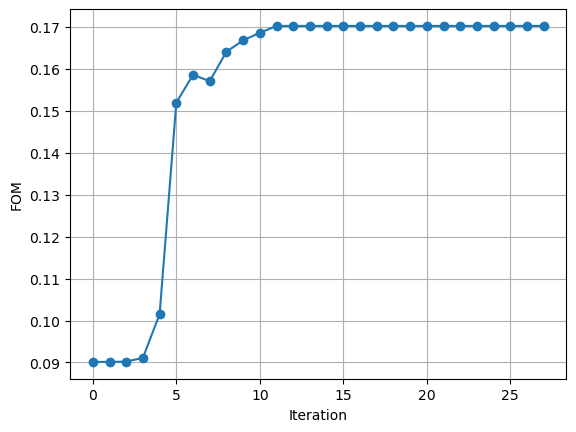

In [11]:
plt.figure()

plt.plot(evaluation_history, "o-")
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("FOM")
plt.show()

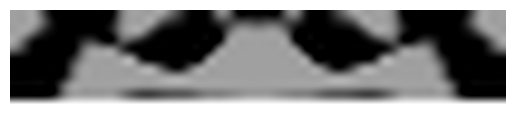

In [12]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(
    False,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    ax=ax,
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

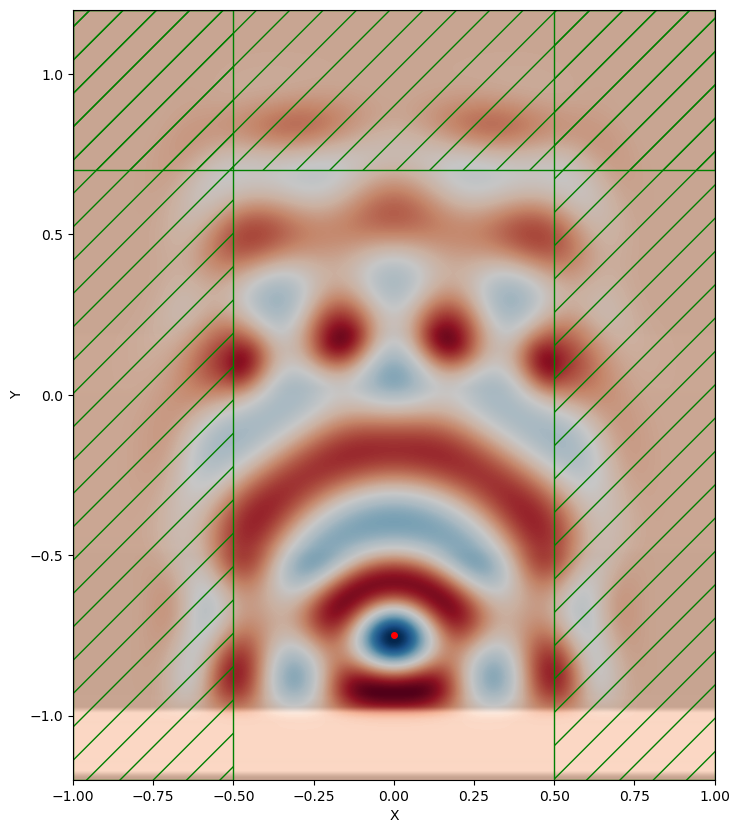

In [13]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))]
opt.sim.change_sources(source)

plt.figure(figsize=(16, 10))

opt.sim.run(until=300)
opt.sim.plot2D(fields=mp.Ez)
opt.sim.reset_meep()

In [14]:
opt.sim.reset_meep()

In [15]:
opt.sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,)

In [16]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = 0.05
srcbox_top = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.sim.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))



<Axes: xlabel='X', ylabel='Y'>

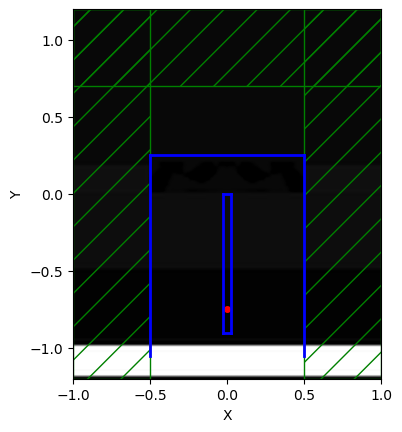

In [17]:
opt.sim.plot2D()

In [18]:
opt.sim.run(until=100.0)

In [19]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)



In [20]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

In [21]:
print(flux_waveguide)

[4.50404194e-06 2.36106866e-05 1.10103889e-04 4.54671207e-04
 1.69307503e-03 5.72344569e-03 1.63305176e-02 3.97381933e-02
 8.20443152e-02 1.41002417e-01 2.21664165e-01 3.26646638e-01
 4.44514823e-01 4.32097832e-01 3.44078453e-01 2.65351415e-01
 1.84646744e-01 1.05318636e-01 5.22834568e-02 2.24226834e-02
 8.16449234e-03 2.58227454e-03 7.26062172e-04 1.78804705e-04
 3.89345313e-05]


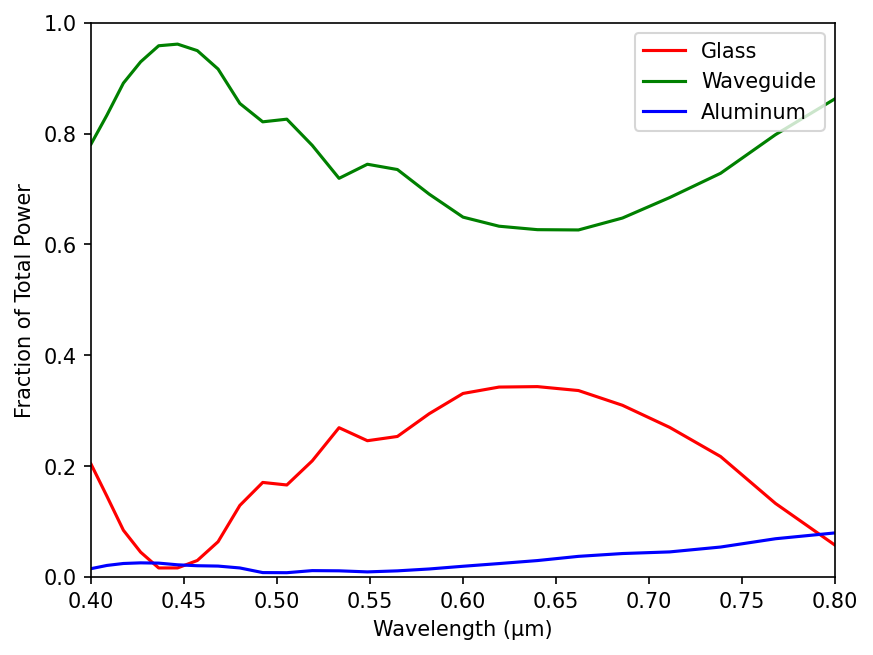

In [22]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

In [23]:
geometryo = [
    mp.Block(material=GLS,      # 유리층
             size=mp.Vector3(mp.inf, tPML + tGLS),
             center=mp.Vector3(y=0.5*Sy - 0.5*(tPML + tGLS))),

    mp.Block(material=GLS,      # 디자인 영역
             size=mp.Vector3(mp.inf, design_region_height),
             center=design_region.center),
    
    mp.Block(material=ITO,      # ITO 층
             size=mp.Vector3(mp.inf, tITO),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - 0.5*tITO)),
    
    mp.Block(material=ORG,                       # 유기층
             size=mp.Vector3(mp.inf, tORG),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG)),
    
    mp.Block(material=ALU,                       # 알루미늄 층
             size=mp.Vector3(mp.inf, tALU),
             center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - tORG - 0.5*tALU))
]

In [24]:
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)

In [25]:
# surround source with a six-sided box of flux planes                                                             
srcbox_width = 0.05
srcbox_top = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height), size=mp.Vector3(srcbox_width,0,0)))
srcbox_bot = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-tGLS-design_region_height-tITO-0.8*tORG), size=mp.Vector3(srcbox_width,0,0)))
srcbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))
srcbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(-0.5*srcbox_width,0.5*Sy-tPML-tGLS-design_region_height-0.5*(tITO+0.8*tORG)), size=mp.Vector3(0,tITO+0.8*tORG)))

# padding for flux box to fully capture waveguide mode                                                            
fluxbox_dpad = 0.05

glass_flux = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(y=0.5*Sy-tPML-(tGLS-fluxbox_dpad)), size = mp.Vector3(L,0,0)))
wvgbox_right = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))
wvgbox_left = opt.simo.add_flux(fcen, df, nfreq, mp.FluxRegion(size=mp.Vector3(0,fluxbox_dpad+design_region_height+tITO+tORG+fluxbox_dpad), center=mp.Vector3(-0.5*L,0.5*Sy-tPML-tGLS-0.5*(design_region_height+tITO+tORG))))


<Axes: xlabel='X', ylabel='Y'>

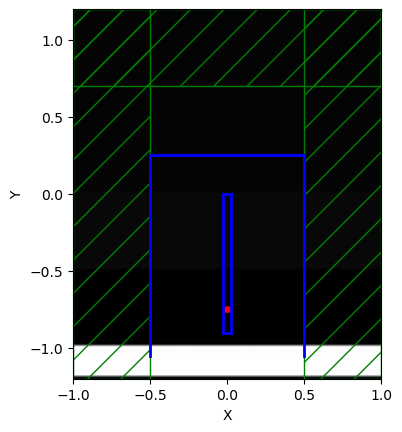

In [26]:
opt.simo.plot2D()

In [27]:
opt.simo.run(until=300.0)

In [28]:
flux_srcbox_top = np.asarray(mp.get_fluxes(srcbox_top))
flux_srcbox_bot = np.asarray(mp.get_fluxes(srcbox_bot))
flux_srcbox_right = np.asarray(mp.get_fluxes(srcbox_right))
flux_srcbox_left = np.asarray(mp.get_fluxes(srcbox_left))

flux_glass = np.asarray(mp.get_fluxes(glass_flux))
flux_wvgbox_right = np.asarray(mp.get_fluxes(wvgbox_right))
flux_wvgbox_left = np.asarray(mp.get_fluxes(wvgbox_left))

flux_freqs = mp.get_flux_freqs(glass_flux)


In [29]:
flux_total_srcbox = flux_srcbox_top - flux_srcbox_bot + flux_srcbox_right - flux_srcbox_left
flux_total_glass = flux_glass
flux_waveguide = flux_wvgbox_right - flux_wvgbox_left

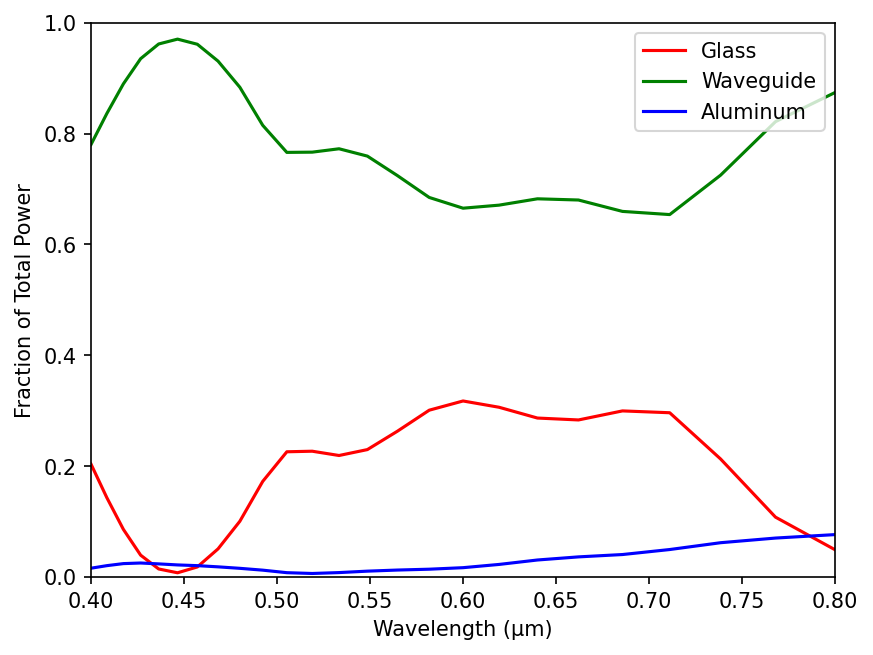

In [30]:
# totalflux 대비 효율

wl = []
gl = []
wg = []
al = []
for d in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[d]))
    gl = np.append(gl, flux_total_glass[d] / flux_total_srcbox[d])
    wg = np.append(wg, flux_waveguide[d] / flux_total_srcbox[d])
    al = 1 - gl - wg


if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, gl, "r", label="Glass")
    plt.plot(wl, wg, "g", label="Waveguide")
    plt.plot(wl, al, "b", label="Aluminum")

    
    plt.axis([0.40, 0.80, 0, 1])
    plt.xlabel("Wavelength (μm)")
    plt.ylabel("Fraction of Total Power")
    plt.legend(loc="upper right")
    plt.show()
    plt.cla()   # clear the current axes
    plt.clf()   # clear the current figure
    plt.close() # closes the current figure

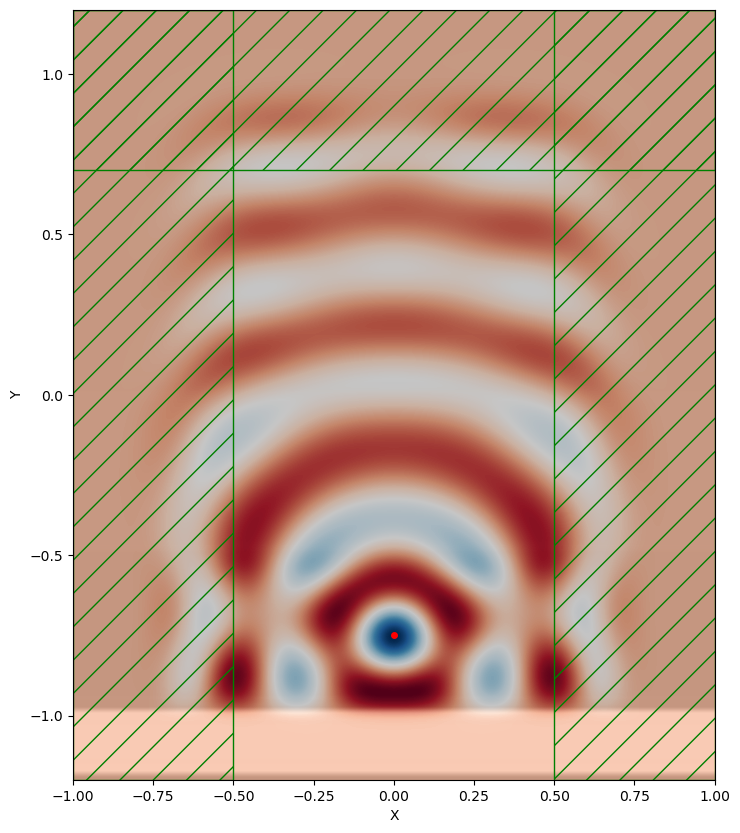

In [31]:
opt.simo.reset_meep()
opt.simo = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometryo,
                    sources=sources,)
src = mp.ContinuousSource(frequency=fcen, fwidth=df, is_integrated=True)
source = [mp.Source(src, component=mp.Ez, center=mp.Vector3(y=0.5*Sy - tPML - tGLS - design_region_height - tITO - 0.5*tORG))]
opt.simo.change_sources(source)

plt.figure(figsize=(16, 10))

opt.simo.run(until=300)
opt.simo.plot2D(fields=mp.Ez)
opt.simo.reset_meep()